<a href="https://colab.research.google.com/github/RyanChen12035/w281_final_galaxy_zoo/blob/main/image_preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

# mount Google Drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
LOCAL=True

In [20]:
import os
if LOCAL:
    image_dir = "Train_images/Train_images/Cigar-shaped smooth"
    image_dir_cigar = "Train_images/Train_images/Cigar-shaped smooth"
    image_dir_round = "Train_images/Train_images/Completely round smooth"
else:
    image_dir = '/content/drive/MyDrive/galaxy_zoo/Train_images/Train_images/Cigar-shaped smooth'
    image_dir_cigar = '/content/drive/MyDrive/galaxy_zoo/Train_images/Train_images/Cigar-shaped smooth'
    image_dir_round = '/content/drive/MyDrive/galaxy_zoo/Train_images/Train_images/Completely round smooth'

image_files = os.listdir(image_dir)
print(len(image_files))

# get the path of image in the list
image_path = os.path.join(image_dir, image_files[0])

579


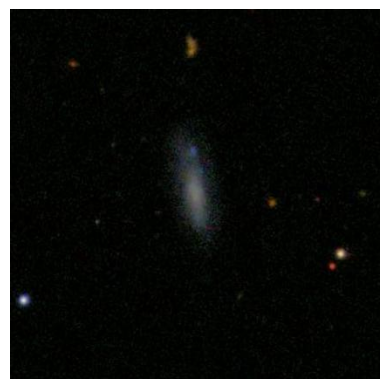

In [3]:
# print out the image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()

In [21]:
import pandas as pd

#csv_file_path = '/content/drive/MyDrive/galaxy_zoo/train_label.csv'
csv_file_path = 'train_label.csv'
column_names = ['index', 'class']

df = pd.read_csv(csv_file_path, names=column_names)
# create a dictionary for index and class
index_to_class = dict(zip(df['index'], df['class']))

Index: 100740
Class0


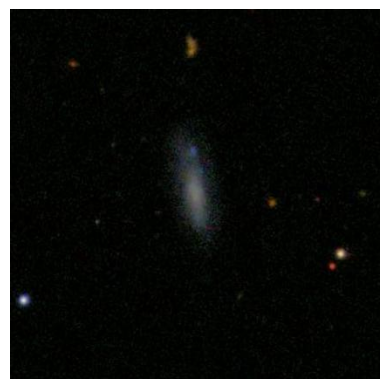

In [22]:
image_path = os.path.join(image_dir, image_files[0])
filename = os.path.basename(image_path)
index = filename.split('.')[0]
index = int(index)

# Print the index
print("Index:", index)
print(index_to_class[index])

img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Turn off axis
plt.show()

Refer to the filters used in exercise 7

In [23]:
# copy the filters from ex7
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable
from PIL import Image
import urllib

(424, 424, 3)


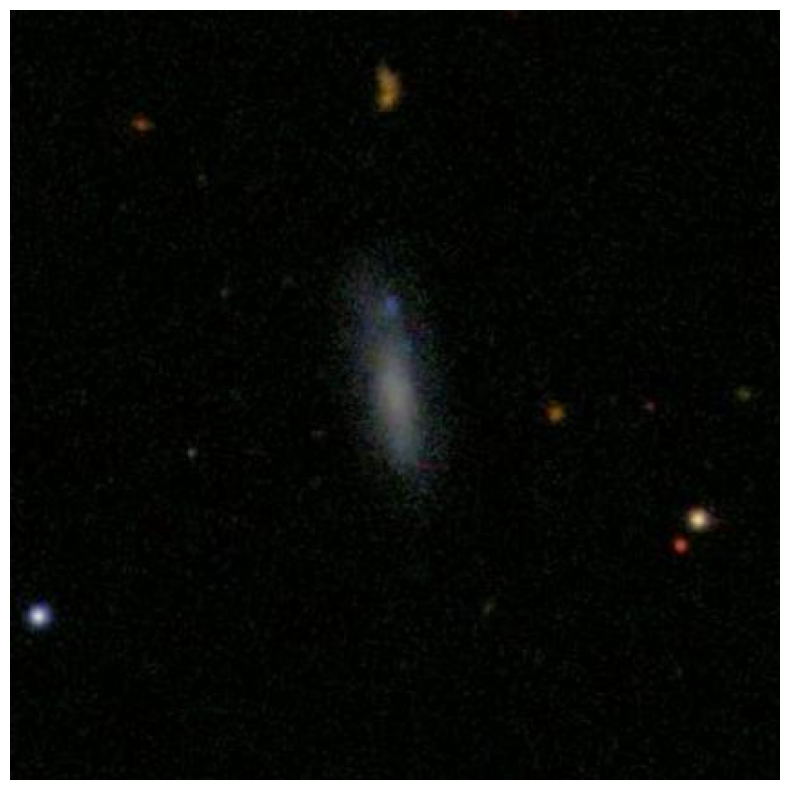

In [24]:
image_path = os.path.join(image_dir, image_files[0])
im = np.array(Image.open(image_path))
print(im.shape)

# display the image
plt.figure(figsize=(15,10))
plt.axis('off')
plt.imshow(im)
plt.show()

In [25]:
def display_img_colorbar(img):
  # display the points
  fig, ax = plt.subplots(figsize=(15, 10))
  im_ax = plt.imshow(img, cmap='gray')
  # create an axes on the right side of ax. The width of cax will be 5%
  # of ax and the padding between cax and ax will be fixed at 0.05 inch.
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  plt.colorbar(im_ax, cax=cax)
  plt.show()

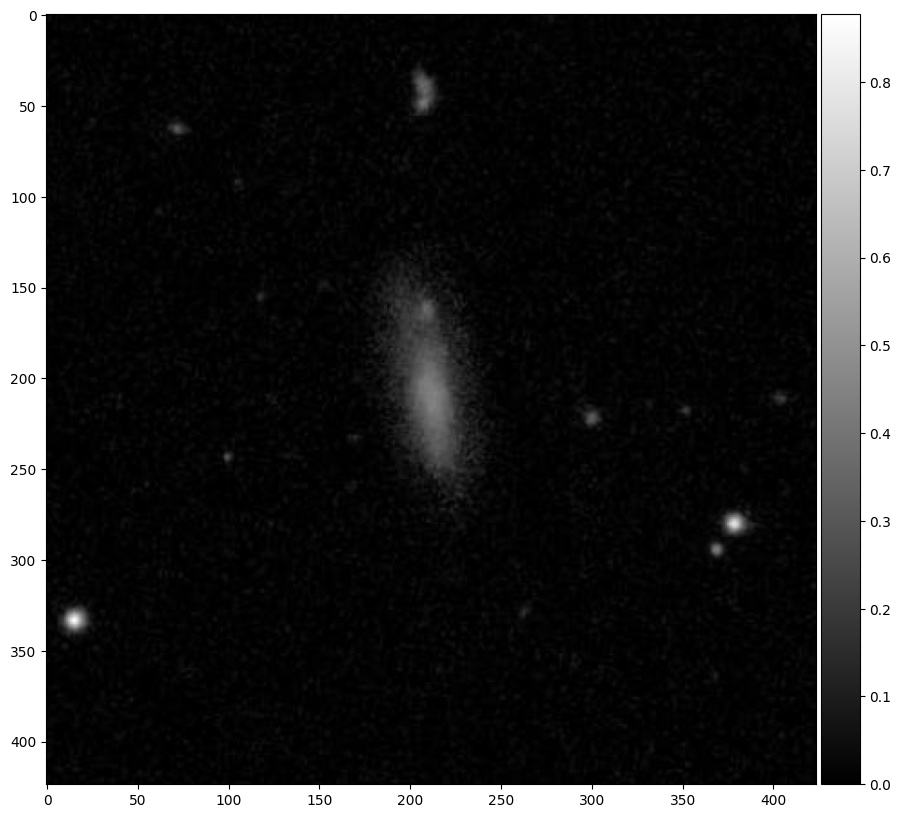

In [26]:
# convert to grayscale
def grayscale_preprocessing(img):
  if np.max(img)>1:
    img = img.astype(np.float32)/255.0
  im_gray = np.mean(img, axis=2)
  return im_gray

im_gray = grayscale_preprocessing(im)
display_img_colorbar(im_gray)

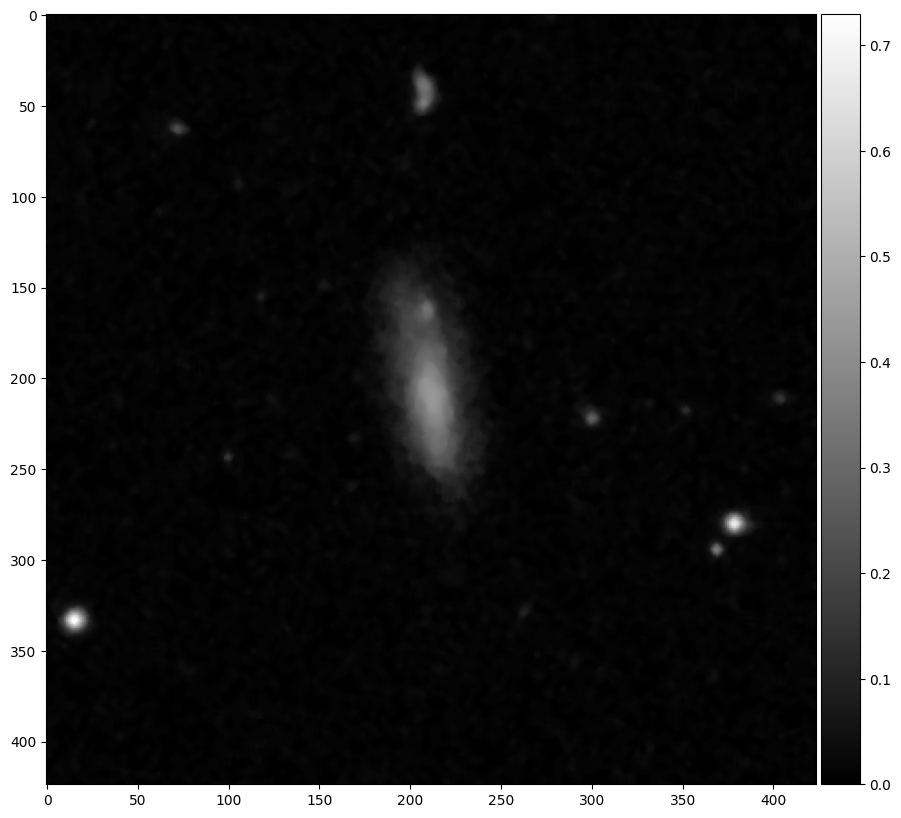

In [27]:
# median filter, replaces each pixel's value with the median value of the intensities in the neighborhood of that pixel
# kernel size = 5, A larger kernel size will have a more significant smoothing effect
def median_preprocessing(img, ksize):
  median_filtered_image = cv2.medianBlur(img, ksize)
  return median_filtered_image

median_filtered_image = median_preprocessing(im_gray, 5)
display_img_colorbar(median_filtered_image)

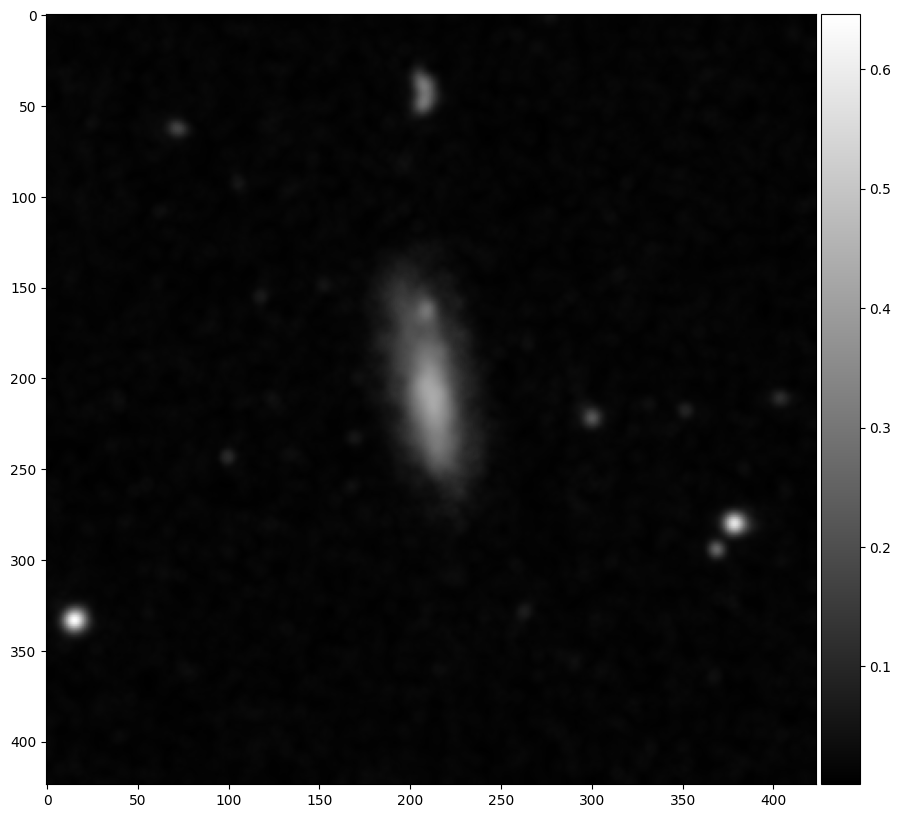

In [28]:
# This filter is more advanced and can reduce noise while keeping edges sharp. It does this by considering both the spatial proximity and the intensity similarity.
def bilateral_preprocessing(img, ksize, sigmX, sigmY):
  bilateral_filtered_image = cv2.bilateralFilter(img, ksize, sigmX, sigmY)
  return bilateral_filtered_image

bilateral_filtered_image = bilateral_preprocessing(im_gray, 9, 75, 75)
display_img_colorbar(bilateral_filtered_image)

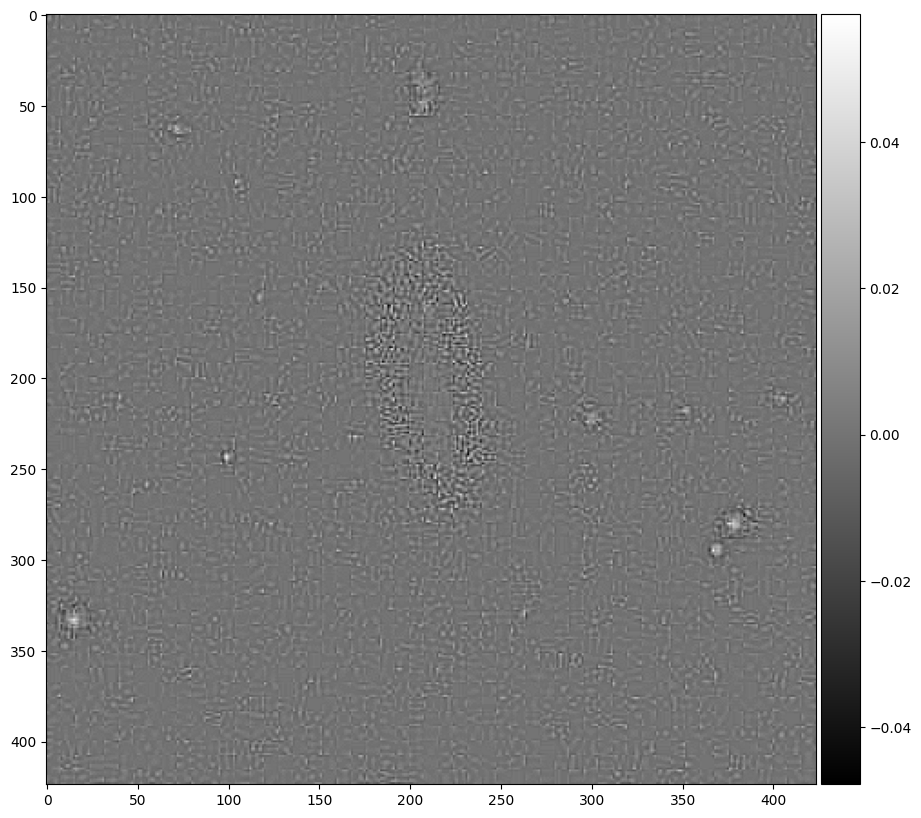

In [29]:
# high pass freqeuncies are noises
def high_pass_preprocessing(img, ksize, sig):
  low_pass = cv2.GaussianBlur(img, ksize, 0)
  high_pass = img - low_pass
  return high_pass

high_pass_img = high_pass_preprocessing(im_gray, (3,3), 0)
display_img_colorbar(high_pass_img)

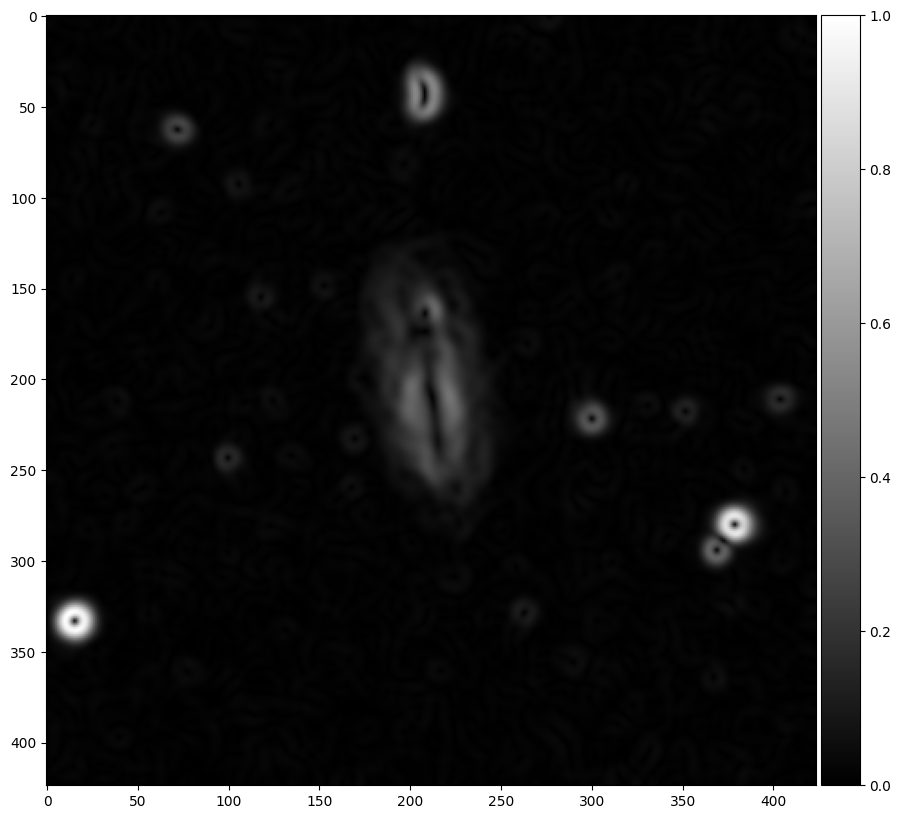

In [30]:
# compute edges of the image
# the larger kernel size is, the clearer the image we have. Small kernal would make the image fuzzy and full of noises.
def sobel_preprocessing(img, ksize):
  sobelx = cv2.Sobel(img, cv2.CV_32F, 1, 0, ksize=ksize) # Find x and y gradients
  sobely = cv2.Sobel(img, cv2.CV_32F, 0, 1, ksize=ksize)
  magnitude = np.sqrt(sobelx**2.0 + sobely**2.0)
  magnitude = magnitude / np.max(magnitude) # normalize
  return magnitude

sobel_img = sobel_preprocessing(bilateral_filtered_image, 31)
display_img_colorbar(sobel_img)

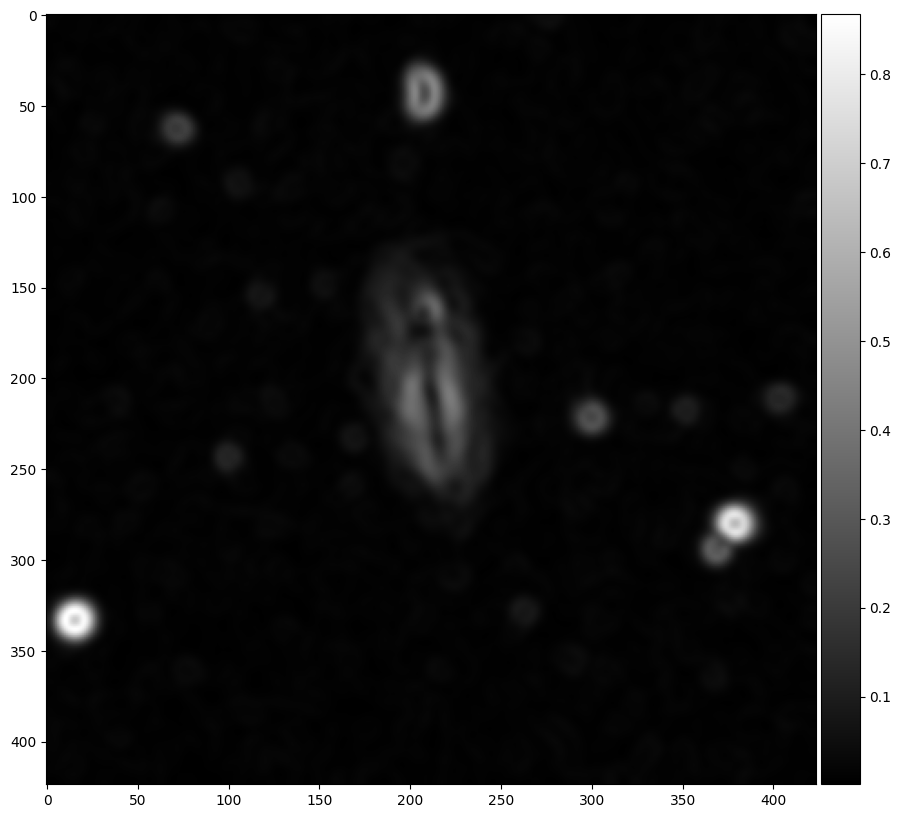

In [31]:
# GaussianBlur before canny to reduce the noise
# Arguments: kernel size (width, height), sigmaX and sigmaY
# Default setting sigma = 0.3*((ksize-1)*0.5 - 1) + 0.8
# if the kernel has wider tails, the image will be more blurred or higher sigma

def gaussian_blur_preprocessing(img, ksize, sigma):
  blurred_im = cv2.GaussianBlur(img, ksize, sigmaX=sigma[0], sigmaY=sigma[1])
  return blurred_im

blurred_im = gaussian_blur_preprocessing(sobel_img, (7, 7), (16, 10))
display_img_colorbar(blurred_im)

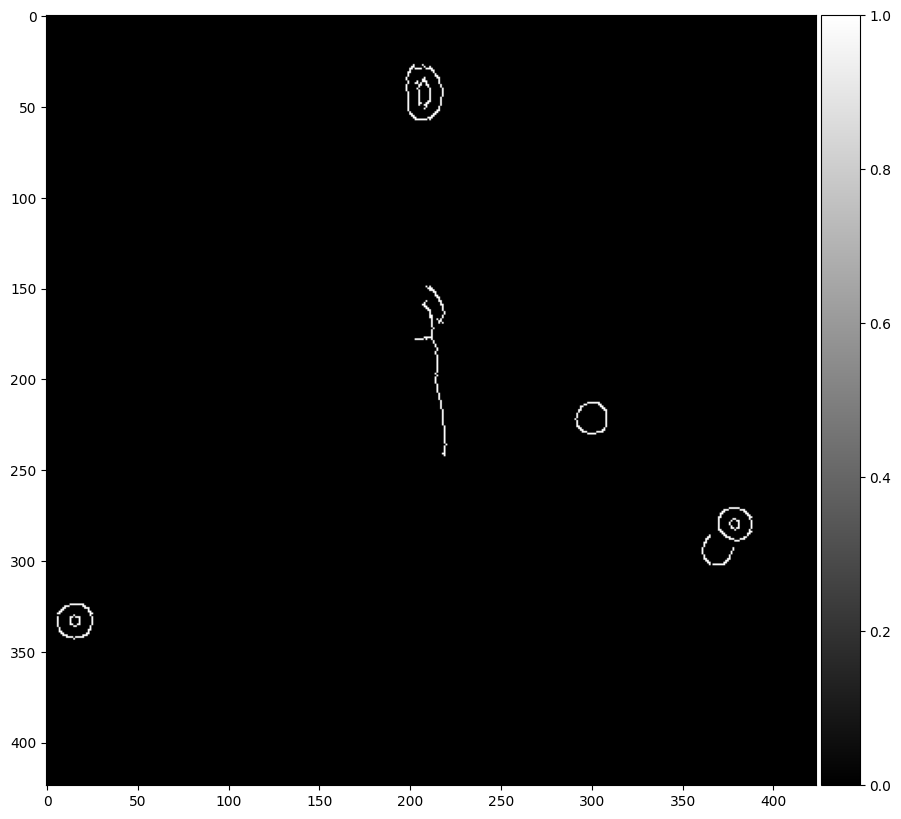

In [32]:
def canny_filter(img, high_threshold, low_threshold):
  # ensure the image is normalized to the range [0, 1]
  img = img / np.max(img)
  # scale the image to the range [0, 255] and convert to 8-bit
  img_8u = np.uint8(img * 255)
  # threshold the image and get the interesting points
  # The high threshold is used to identify the strong edges. Pixels with intensity gradients above this threshold are marked as strong edge pixels.
  # The low threshold is used to identify the non-edges. Pixels with intensity gradients below this threshold are suppressed.
  # By setting the high threshold too low, many pixels might be considered as strong edges, leading to a noisy edge image. Similarly, if the low threshold is set too high, you might miss genuine weak edges that should contribute to the final edge image.

  im_threshold = cv2.Canny(image=img_8u, threshold1=low_threshold, threshold2=high_threshold) # Canny Edge
  im_threshold = im_threshold / np.max(im_threshold) # normalize
  return im_threshold

img_canny = canny_filter(blurred_im, 120, 30)
display_img_colorbar(img_canny)

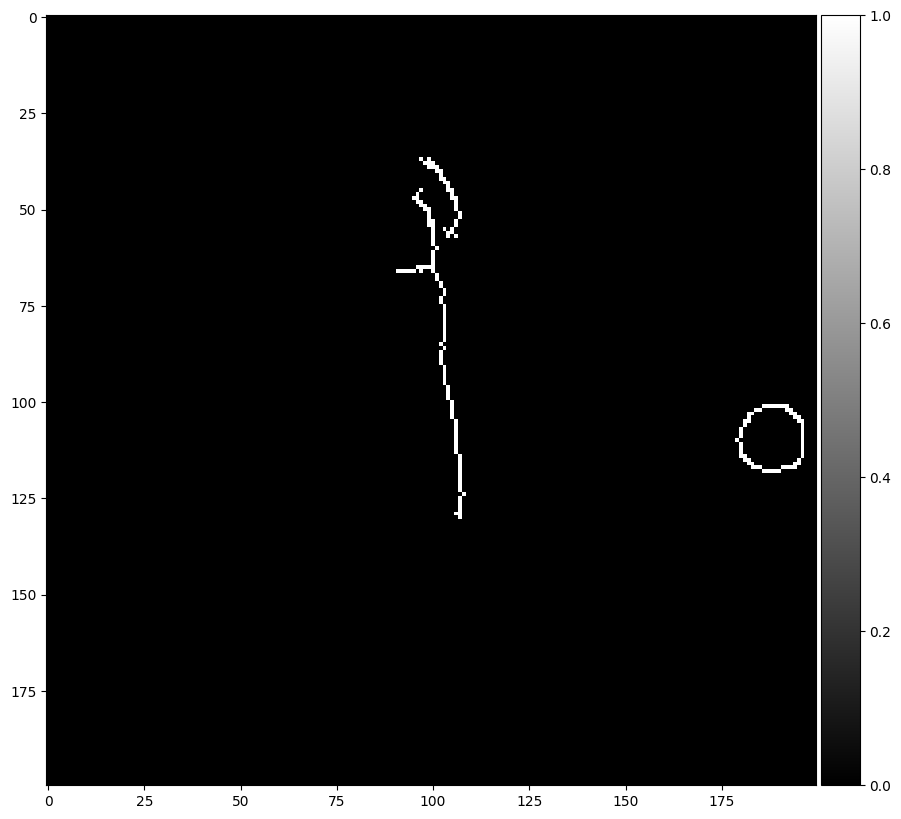

In [34]:
def crop_center(img, cropx, cropy):
    y, x = img.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return img[starty:starty+cropy, startx:startx+cropx]

display_img_colorbar(crop_center(img_canny, 200, 200))

In [35]:
def draw_histogram(equalized_image):
  num_bins = 36

  # Compute the histogram for each channel with 36 bins
  hist_r_data_36_bins = cv2.calcHist([equalized_image], [0], None, [num_bins], [0,256]).ravel()
  hist_g_data_36_bins = cv2.calcHist([equalized_image], [1], None, [num_bins], [0,256]).ravel()
  hist_b_data_36_bins = cv2.calcHist([equalized_image], [2], None, [num_bins], [0,256]).ravel()

  # Define the bin edges for 36 bins
  bin_edges = np.linspace(0, 255, num_bins+1, endpoint=True)

  # Plot the histograms with 36 bins for each channel
  plt.figure(figsize=(18, 6))

  # Red channel histogram
  plt.subplot(1, 3, 1)
  plt.bar(bin_edges[:-1], hist_r_data_36_bins, width=(256/num_bins), color='red', alpha=0.6)
  plt.title('Histogram for Red Channel - 36 Bins')
  plt.xlim([0, 256])

  # Green channel histogram
  plt.subplot(1, 3, 2)
  plt.bar(bin_edges[:-1], hist_g_data_36_bins, width=(256/num_bins), color='green', alpha=0.6)
  plt.title('Histogram for Green Channel - 36 Bins')
  plt.xlim([0, 256])

  # Blue channel histogram
  plt.subplot(1, 3, 3)
  plt.bar(bin_edges[:-1], hist_b_data_36_bins, width=(256/num_bins), color='blue', alpha=0.6)
  plt.title('Histogram for Blue Channel - 36 Bins')
  plt.xlim([0, 256])

  plt.tight_layout()
  plt.show()



def histogram_equalization(img):
  image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  draw_histogram(image_rgb)
  # RGB to YCrCb
  image_YCrCb = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2YCrCb)

  # histogram_equalization for intensity
  image_YCrCb[:, :, 0] = cv2.equalizeHist(image_YCrCb[:, :, 0])
  # back to RGB
  equalized_image = cv2.cvtColor(image_YCrCb, cv2.COLOR_YCrCb2RGB)
  draw_histogram(equalized_image)
  return equalized_image


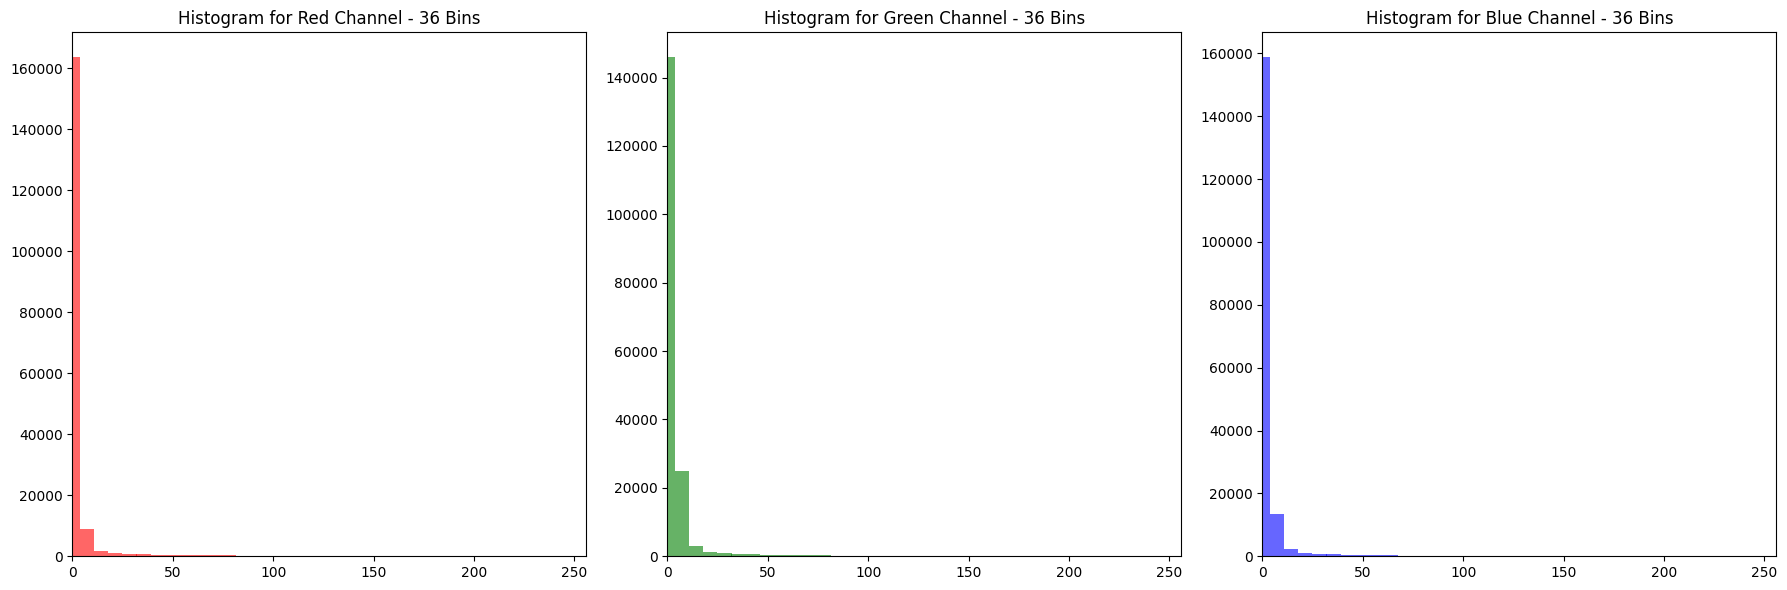

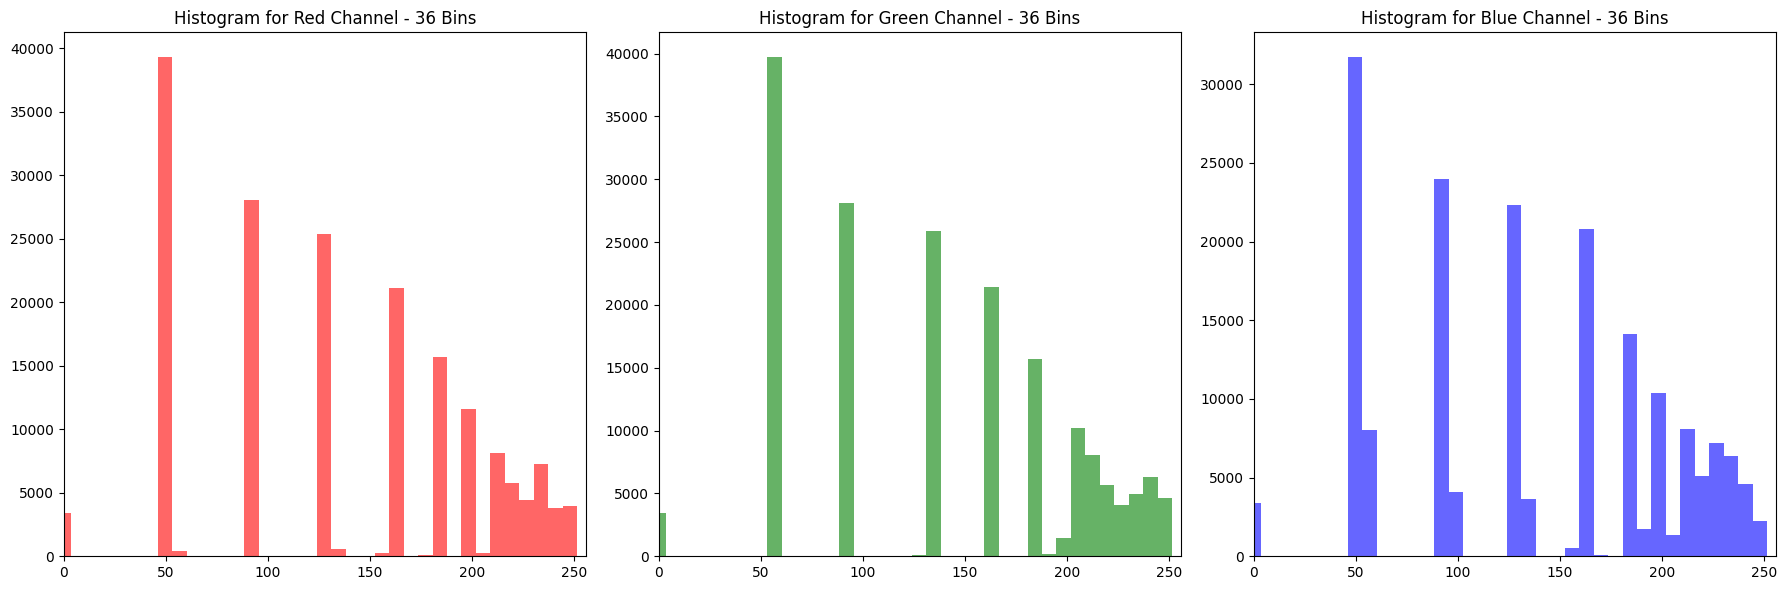

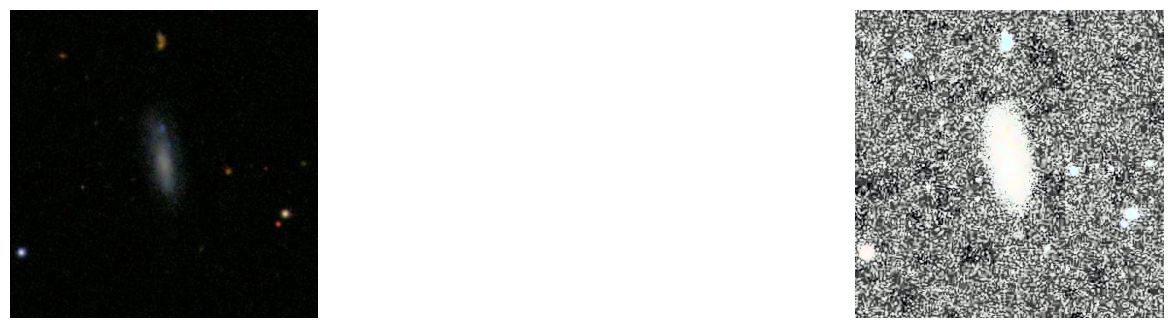

In [36]:
image_dir = '/content/drive/MyDrive/galaxy_zoo/Train_images/Train_images/Cigar-shaped smooth'
image_dir = image_dir_cigar
image_files = os.listdir(image_dir)

image_path = os.path.join(image_dir, image_files[0])
im = np.array(Image.open(image_path))
img_list = [im]

im_histogram_equalization = histogram_equalization(im)
img_list.append(im_histogram_equalization)

plot_stages(img_list)

# histogram_equalization would increase the contrast but somehow bring up the noise in the black back ground. We need clipping only.

In [37]:
def histogram_clipping_equalization(img, threshold_value):
  image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  draw_histogram(image_rgb)

  # RGB to YCrCb
  image_YCrCb = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2YCrCb)
  #clip it before equalization
  clipped_image = image_YCrCb.copy()
  clipped_image[image_YCrCb < threshold_value] = 0


  # histogram_equalization for intensity
  clipped_image[:, :, 0] = cv2.equalizeHist(clipped_image[:, :, 0])
  # back to RGB
  equalized_image = cv2.cvtColor(clipped_image, cv2.COLOR_YCrCb2RGB)
  draw_histogram(equalized_image)
  return equalized_image


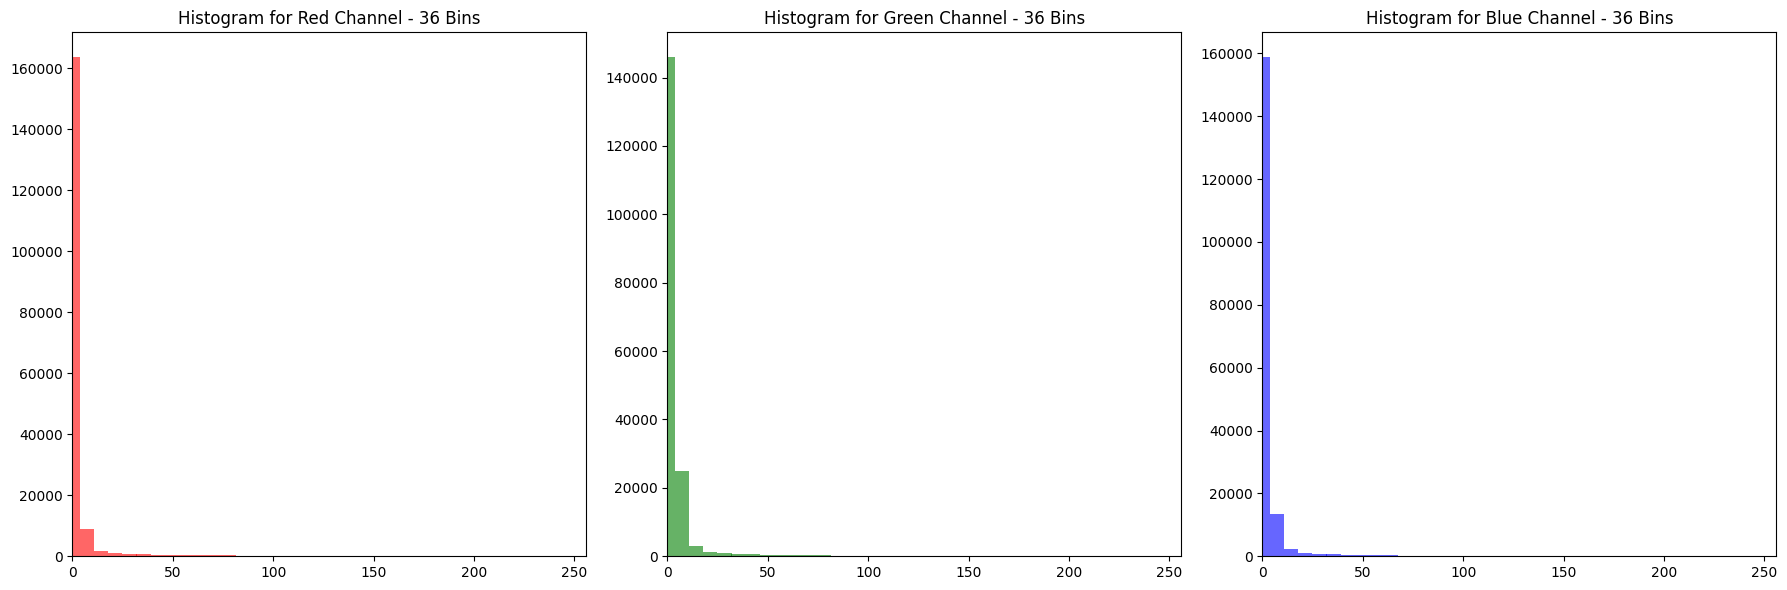

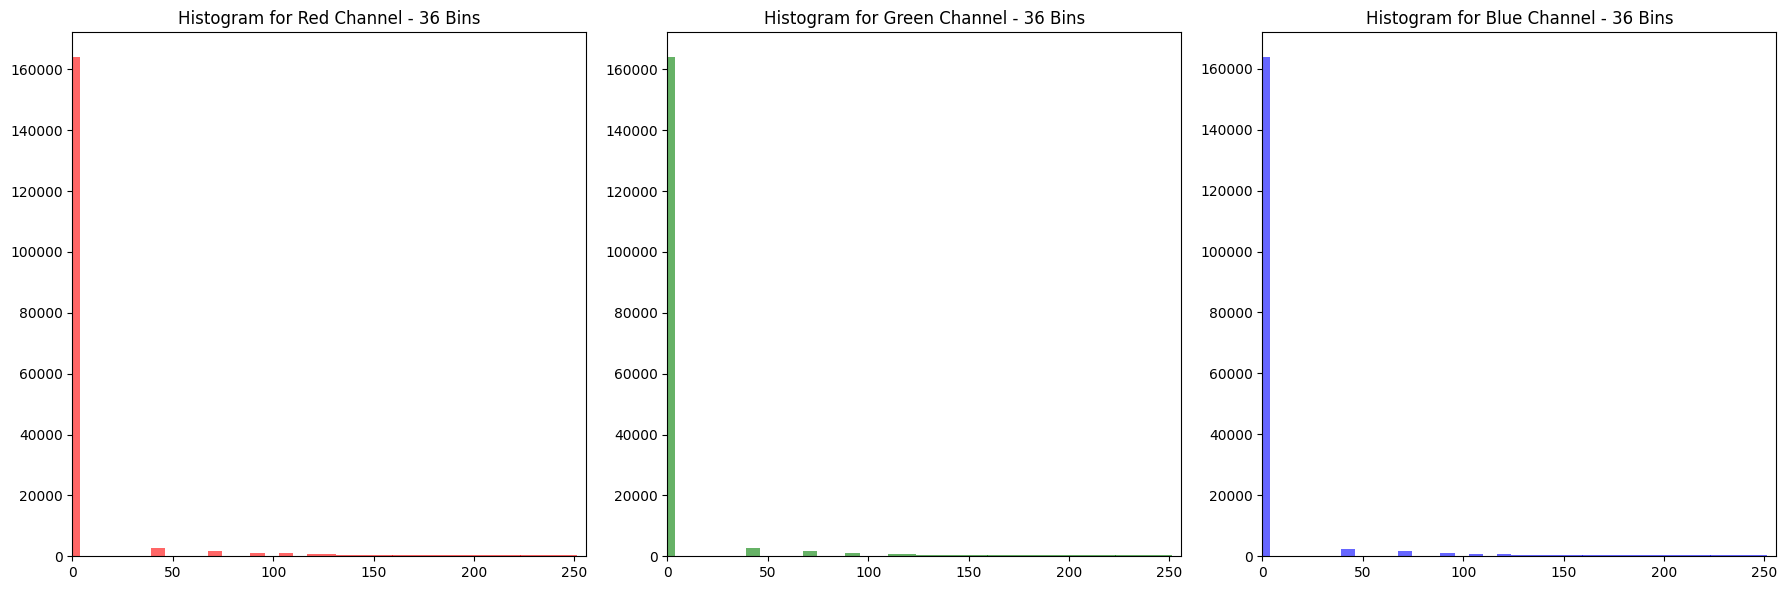

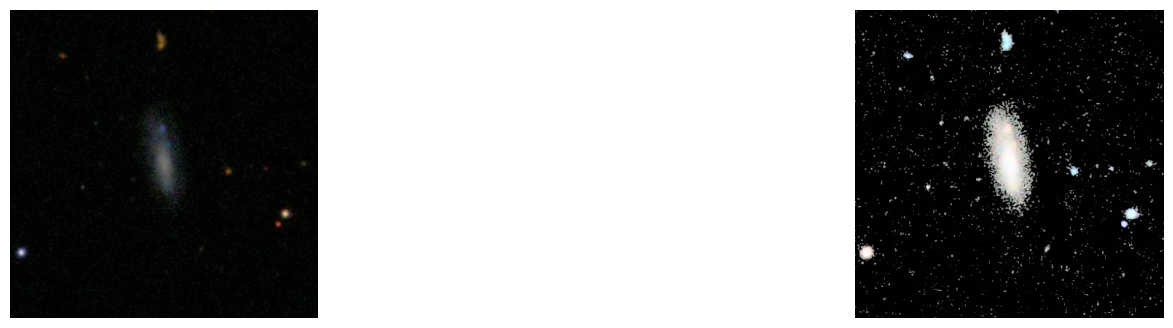

In [38]:
image_dir = '/content/drive/MyDrive/galaxy_zoo/Train_images/Train_images/Cigar-shaped smooth'
image_dir = image_dir_cigar
image_files = os.listdir(image_dir)

image_path = os.path.join(image_dir, image_files[0])
im = np.array(Image.open(image_path))
img_list = [im]

im_histogram_equalization = histogram_clipping_equalization(im, 10)
img_list.append(im_histogram_equalization)



plot_stages(img_list)

In [39]:
def draw_histogram_gray(img_gray):
  # Plotting the histogram for the grayscale image after preprocessing
  histogram, bin_edges = np.histogram(img_gray.ravel(), bins=36, range=[0, 1])

  # Normalize bin_edges to 0-255 for display purposes
  bin_edges_255 = bin_edges * 255

  # Plot the histogram
  plt.figure(figsize=(6, 4))
  plt.bar(bin_edges_255[:-1], histogram, width=bin_edges_255[1] - bin_edges_255[0], color='gray')
  plt.title('Histogram for Preprocessed Grayscale Image')
  plt.xlabel('Intensity Value')
  plt.ylabel('Pixel Count')
  plt.xlim([0, 255])
  plt.show()

def histogram_clipping(img, threshold_value):
  clipped_image = img.copy()
  # before
  # draw_histogram_gray(clipped_image)
  clipped_image[img < threshold_value/255.0] = 0
  # Normalize the clipped_image to 0-255 for proper histogram visualization
  normalized_clipped_image = cv2.normalize(clipped_image, None, alpha=0, beta=255,
                                             norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
  # draw_histogram_gray(clipped_image)
  return normalized_clipped_image

In [40]:
im_gray = grayscale_preprocessing(im)
histogram_clipping(im_gray, 30)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

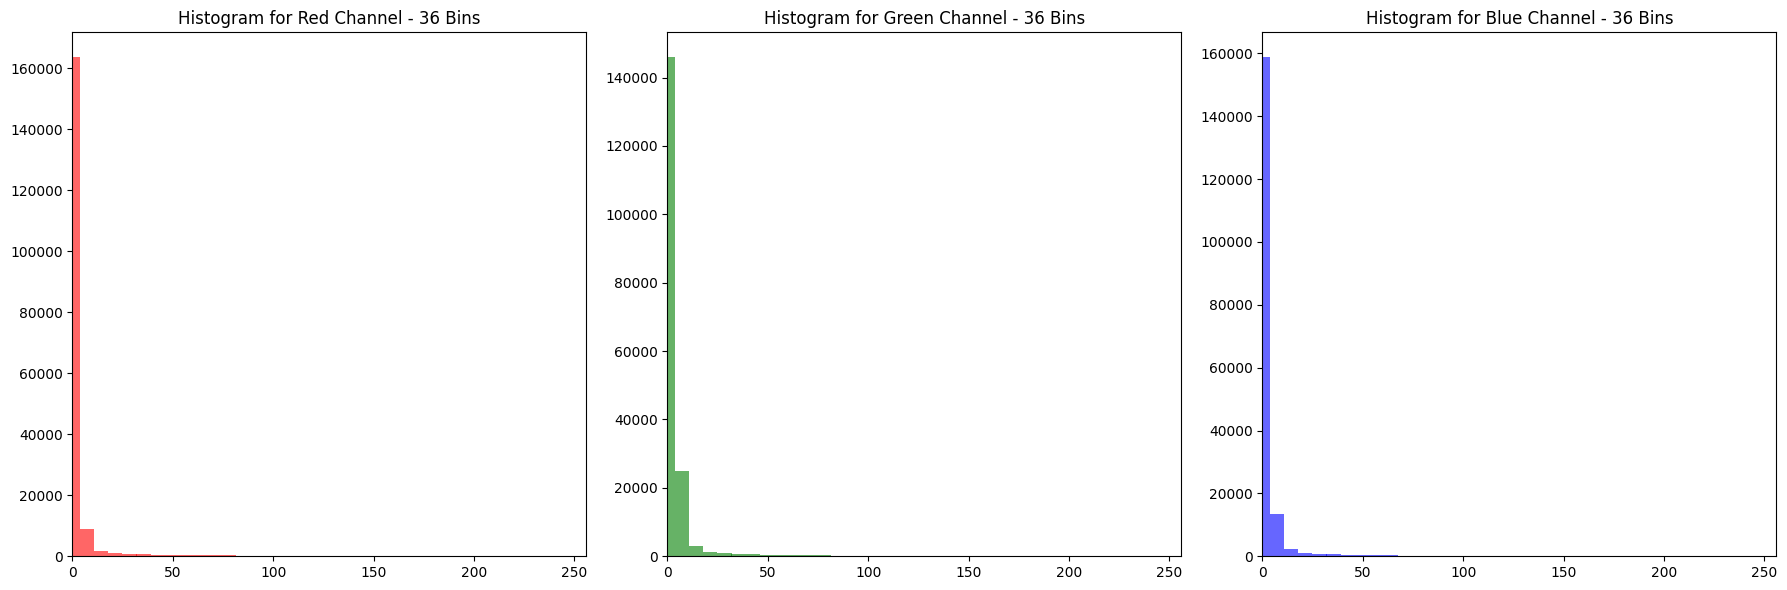

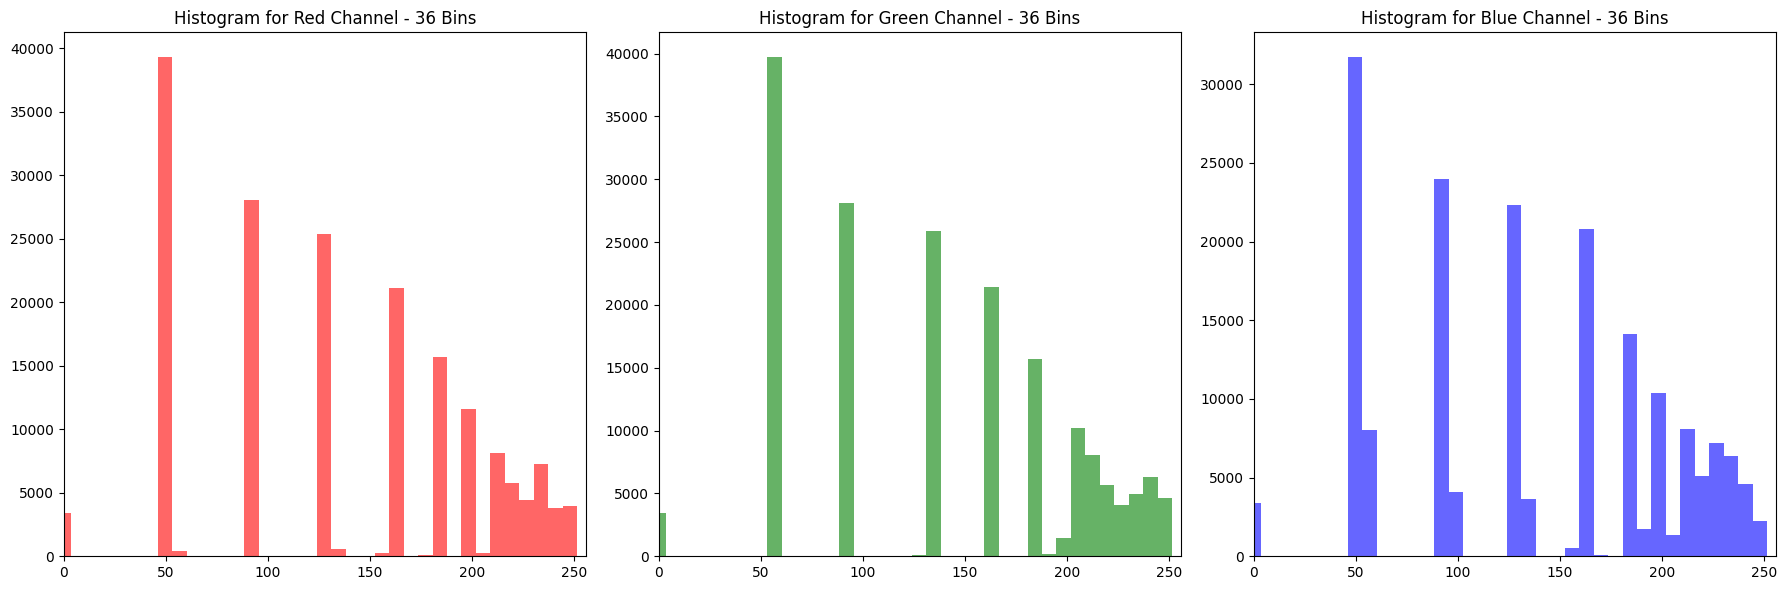

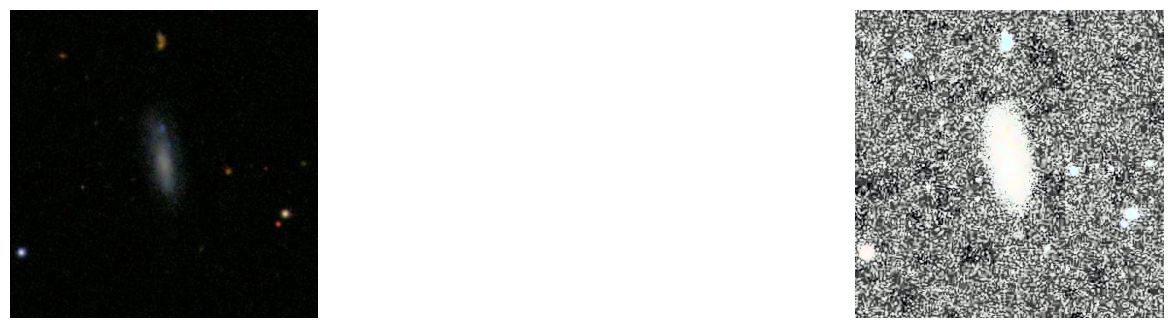

In [43]:
image_dir = '/content/drive/MyDrive/galaxy_zoo/Train_images/Train_images/Cigar-shaped smooth'
image_dir = image_dir_cigar
image_files = os.listdir(image_dir)

image_path = os.path.join(image_dir, image_files[0])
im = np.array(Image.open(image_path))
img_list = [im]

im_histogram_equalization = histogram_equalization(im)
img_list.append(im_histogram_equalization)

plot_stages(img_list)

# histogram_equalization would increase the contrast but somehow bring up the noise in the black back ground. We need clipping only.

In [44]:
def plot_stages(img_list):
  fig, axes = plt.subplots(nrows=1, ncols=len(img_list), figsize=(20, 4))
  for i, img in enumerate(img_list):
    axes[i].imshow(img, cmap='gray')
    axes[i].axis('off')  # Turn off axis
  plt.show()

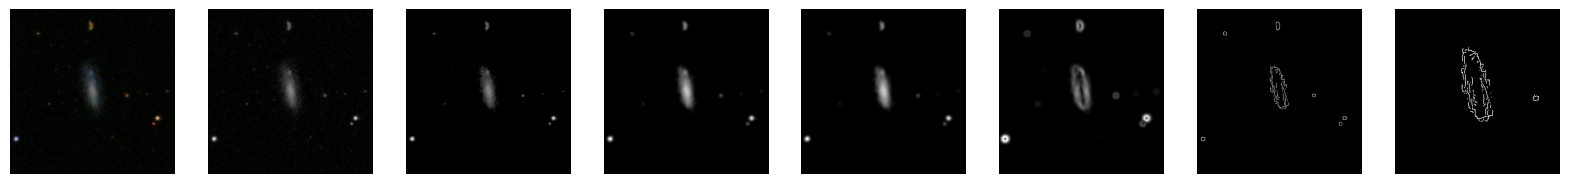

In [45]:
# test 1, bilateral -> sobel -> gaussian_blur -> canny
image_dir = '/content/drive/MyDrive/galaxy_zoo/Train_images/Train_images/Cigar-shaped smooth'
image_dir = image_dir_cigar
image_files = os.listdir(image_dir)

image_path = os.path.join(image_dir, image_files[0])
im = np.array(Image.open(image_path))
img_list = [im]

im_gray = grayscale_preprocessing(im)
img_list.append(im_gray)

img_histogram_clipping = histogram_clipping(im_gray, 30)
img_list.append(img_histogram_clipping)

im_blurred = gaussian_blur_preprocessing(img_histogram_clipping, (9, 9), (10, 10))
img_list.append(im_blurred)

im_bilateral = bilateral_preprocessing(im_blurred, 5, 30, 30)
img_list.append(im_bilateral)

im_sobel = sobel_preprocessing(im_bilateral, 31)
img_list.append(im_sobel)

im_canny = canny_filter(im_blurred, 70, 0)
img_list.append(im_canny)

im_cropped = crop_center(im_canny, 250, 250)
img_list.append(im_cropped)

plot_stages(img_list)
# display_img_colorbar(im_cropped)

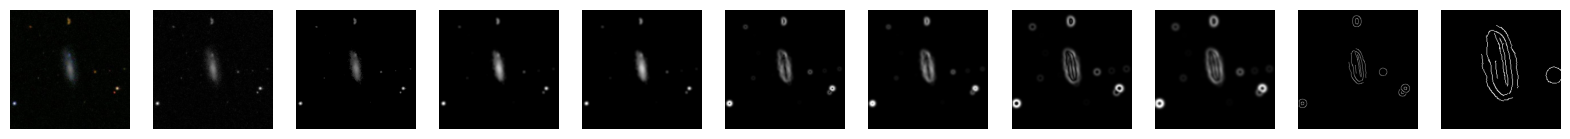

In [46]:
# test 2, bilateral-> sobel -> bilateral -> sobel -> gaussian_blur -> canny
# get the change of the edges: corners
# get the contour of the bright spot in the center
image_dir = '/content/drive/MyDrive/galaxy_zoo/Train_images/Train_images/Cigar-shaped smooth'
image_dir = image_dir_cigar
image_files = os.listdir(image_dir)

image_path = os.path.join(image_dir, image_files[0])
im = np.array(Image.open(image_path))
img_list = [im]

im_gray = grayscale_preprocessing(im)
img_list.append(im_gray)

img_histogram_clipping = histogram_clipping(im_gray, 30)
img_list.append(img_histogram_clipping)

im_blurred = gaussian_blur_preprocessing(img_histogram_clipping, (9, 9), (10, 10))
img_list.append(im_blurred)

im_bilateral = bilateral_preprocessing(im_blurred, 5, 30, 30)
img_list.append(im_bilateral)

im_sobel = sobel_preprocessing(im_bilateral, 31)
img_list.append(im_sobel)

im_bilateral_2 = bilateral_preprocessing(im_sobel, 9, 75, 75)
img_list.append(im_bilateral_2)

im_sobel_2 = sobel_preprocessing(im_bilateral_2, 31)
img_list.append(im_sobel_2)

im_blurred = gaussian_blur_preprocessing(im_sobel_2, (9, 9), (10, 10))
img_list.append(im_blurred)

im_canny = canny_filter(im_blurred, 90, 0)
img_list.append(im_canny)

im_cropped = crop_center(im_canny, 200, 200)
img_list.append(im_cropped)

plot_stages(img_list)
# display_img_colorbar(im_cropped)

8436


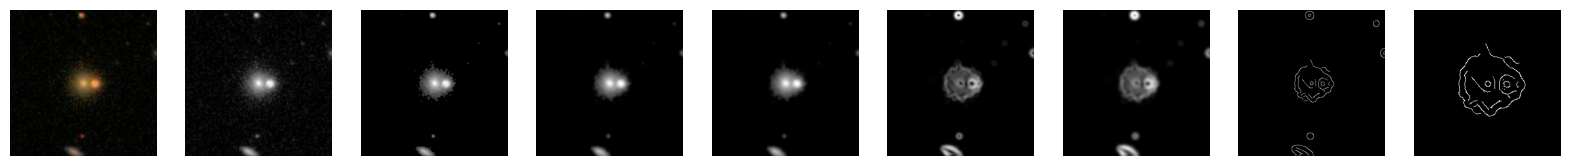

In [47]:
image_dir = '/content/drive/MyDrive/galaxy_zoo/Train_images/Train_images/completely round smooth'
image_dir = image_dir_round
image_files = os.listdir(image_dir)
print(len(image_files))

image_path = os.path.join(image_dir, image_files[2])
im = np.array(Image.open(image_path))
img_list = [im]

im_gray = grayscale_preprocessing(im)
img_list.append(im_gray)

img_histogram_clipping = histogram_clipping(im_gray, 30)
img_list.append(img_histogram_clipping)

im_blurred = gaussian_blur_preprocessing(img_histogram_clipping, (9, 9), (10, 10))
img_list.append(im_blurred)

im_bilateral = bilateral_preprocessing(im_blurred, 5, 30, 30)
img_list.append(im_bilateral)

im_sobel = sobel_preprocessing(im_bilateral, 31)
img_list.append(im_sobel)

im_blurred = gaussian_blur_preprocessing(im_sobel, (9, 9), (10, 10))
img_list.append(im_blurred)

im_canny = canny_filter(im_blurred, 60, 0)
img_list.append(im_canny)

im_cropped = crop_center(im_canny, 250, 250)
img_list.append(im_cropped)

plot_stages(img_list)

HOG

In [127]:
from skimage import feature, io, color

def hog(img_gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), return_features = False):
  block_norm = 'L1'  # Block normalization method
  # orientations = 9   # Number of orientation bins
  # pixels_per_cell = (8, 8)  # Size of the cell
  # cells_per_block = (3, 3)  # Size of the block

  # Compute the HOG features
  if return_features:
    visualize = False
    hog_features = feature.hog(img_gray,
                               orientations=orientations,
                               pixels_per_cell=pixels_per_cell,
                               cells_per_block=cells_per_block,
                               block_norm=block_norm,
                               visualize=visualize,
                               feature_vector=True)
    # use bow
    hog_features = np.bincount(np.argmax(hog_features.reshape(-1, orientations), 
                                         axis=1),
                              minlength=orientations)
    # normalize to sum to 1
    hog_features = hog_features / np.sum(hog_features)
    # 
  else:
    visualize = True
    hog_features, hog_image = feature.hog(img_gray,
                                        orientations=orientations,
                                        pixels_per_cell=pixels_per_cell,
                                        cells_per_block=cells_per_block,
                                        block_norm=block_norm,
                                        visualize=visualize)
  if return_features:
    return hog_features
  return hog_image

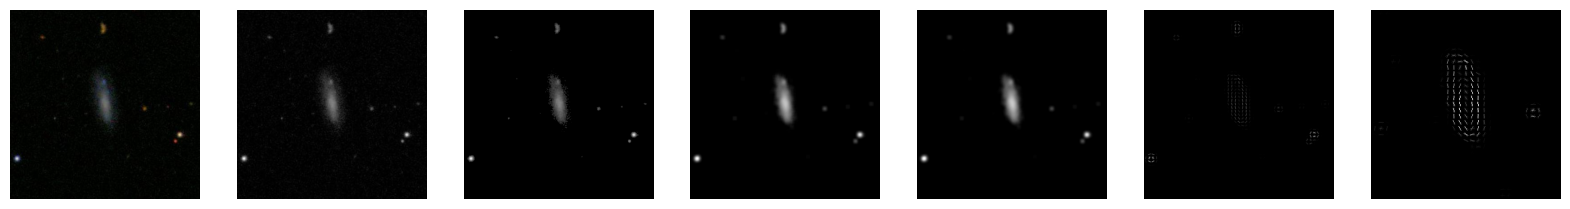

In [115]:
image_dir = '/content/drive/MyDrive/galaxy_zoo/Train_images/Train_images/Cigar-shaped smooth'
image_dir = image_dir_cigar
image_files = os.listdir(image_dir)

image_path = os.path.join(image_dir, image_files[0])
im = np.array(Image.open(image_path))
img_list_preprocess_hog = [im]

im_gray = grayscale_preprocessing(im)
img_list_preprocess_hog.append(im_gray)

img_histogram_clipping = histogram_clipping(im_gray, 30)
img_list_preprocess_hog.append(img_histogram_clipping)

im_blurred = gaussian_blur_preprocessing(img_histogram_clipping, (9, 9), (10, 10))
img_list_preprocess_hog.append(im_blurred)

im_bilateral = bilateral_preprocessing(im_blurred, 5, 30, 30)
img_list_preprocess_hog.append(im_bilateral)

im_hog = hog(im_bilateral)
img_list_preprocess_hog.append(im_hog)

im_cropped = crop_center(im_hog, 250, 250)
img_list_preprocess_hog.append(im_cropped)

plot_stages(img_list_preprocess_hog)


PCA

In [116]:
  image_dir = '/content/drive/MyDrive/galaxy_zoo/Train_images/Train_images/Cigar-shaped smooth'
  image_dir = image_dir_cigar
  image_files = os.listdir(image_dir)

  image_path = os.path.join(image_dir, image_files[0])
  print(len(image_files))
  im = np.array(Image.open(image_path))

579


In [128]:
from tqdm import tqdm
def preprocess_1(image_dir):

  image_files = os.listdir(image_dir)
  preprocessed_list = []

  for i, image_path in enumerate(tqdm(image_files[:500])): #200 examples
    image_path = os.path.join(image_dir, image_files[i])
    im = np.array(Image.open(image_path))

    im_gray = grayscale_preprocessing(im)
    img_histogram_clipping = histogram_clipping(im_gray, 30)
    im_blurred = gaussian_blur_preprocessing(img_histogram_clipping, (9, 9), (10, 10))
    im_bilateral = bilateral_preprocessing(im_blurred, 5, 30, 30)
    im_sobel = sobel_preprocessing(im_bilateral, 31)
    im_canny = canny_filter(im_blurred, 70, 0)
    im_cropped = crop_center(im_canny, 250, 250)
    im_flattened = im_cropped.flatten()
    preprocessed_list.append(im_flattened)

  return preprocessed_list

def preprocess_2(image_dir):

  image_files = os.listdir(image_dir)
  preprocessed_list = []

  for i, image_path in enumerate(tqdm(image_files[:500])): #200 examples
    image_path = os.path.join(image_dir, image_files[i])
    im = np.array(Image.open(image_path))

    im_gray = grayscale_preprocessing(im)
    img_histogram_clipping = histogram_clipping(im_gray, 30)
    im_blurred = gaussian_blur_preprocessing(img_histogram_clipping, (9, 9), (10, 10))
    im_bilateral = bilateral_preprocessing(im_blurred, 5, 30, 30)
    im_hog = hog(im_bilateral)
    im_cropped = crop_center(im_hog, 250, 250)
    im_flattened = im_cropped.flatten()
    preprocessed_list.append(im_flattened)

  return preprocessed_list

def preprocess_3(image_dir):
  """
  Given the image directory, do a gray, histogram clim, blur, bilateral, crop, hog, then return the feature vectors from hog
  """
  image_files = os.listdir(image_dir)
  preprocessed_list = []

  for i, image_path in enumerate(tqdm(image_files[:500])): #200 examples
    image_path = os.path.join(image_dir, image_files[i])
    im = np.array(Image.open(image_path))
    im_gray = grayscale_preprocessing(im)
    img_histogram_clipping = histogram_clipping(im_gray, 30)
    im_blurred = gaussian_blur_preprocessing(img_histogram_clipping, (9, 9), (10, 10))
    im_bilateral = bilateral_preprocessing(im_blurred, 5, 30, 30)
    im_cropped = crop_center(im_bilateral, 250, 250)
    hog_features = hog(im_cropped, return_features=True)
    preprocessed_list.append(hog_features)
    

  return preprocessed_list

In [58]:
image_dir = '/content/drive/MyDrive/galaxy_zoo/Train_images/Train_images/Cigar-shaped smooth'
image_dir = image_dir_cigar
preprocessed_list_1 = preprocess_1(image_dir)
preprocessed_list_2 = preprocess_2(image_dir)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [04:21<00:00,  1.91it/s]


In [129]:
preprocessed_list_3 = preprocess_3(image_dir)

100%|██████████| 500/500 [00:08<00:00, 59.15it/s]


In [ ]:
print(len(preprocessed_list_1), preprocessed_list_1[1].shape, len(preprocessed_list_2), preprocessed_list_2[1].shape)

500 (62500,) 500 (62500,)


In [59]:
feature_matrix_cigar = np.hstack((preprocessed_list_1, preprocessed_list_2))
feature_matrix_cigar.shape

(500, 125000)

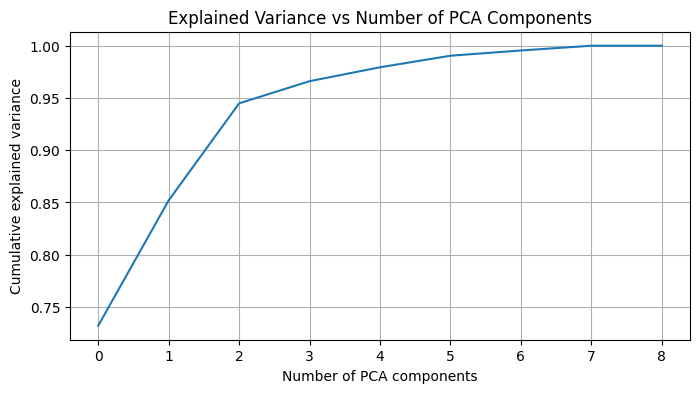

In [132]:
# combine two preprocessed image? or treat them seperately? or by classes?

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
def pca_plot_explained_variance(feature_matrix, n_components=100):
    pca = PCA(n_components=n_components)
    pca.fit(feature_matrix) 
    plt.figure(figsize=(8, 4))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of PCA components')
    plt.ylabel('Cumulative explained variance')
    plt.title('Explained Variance vs Number of PCA Components')
    plt.grid(True)
    plt.show()
    # PCA of cigar-shape, combine two preprocess pipelines, take 500 examples.
pca_plot_explained_variance(preprocessed_array_3, 9)

In [147]:
def generate_features_and_labels(image_di, image_classifications, processing_pipeline=preprocess_1):
    features = np.array([])
    labels = np.array([])
    for idx, image_class in enumerate(image_classifications):
        image_dir = os.path.join(image_di, image_class)
        processed_list = processing_pipeline(image_dir)
        processed_array = np.array(processed_list)
        label = np.ones(processed_array.shape[0]) * idx
        features = np.vstack((features, processed_array)) if features.size else processed_array
        labels = np.hstack((labels, label)) if labels.size else label
    return features, labels
image_classifications = ["Cigar-shaped smooth", "edge-on", "In between smooth", "spiral"]
features, labels = generate_features_and_labels("Train_images/Train_images", image_classifications, preprocess_1)

100%|██████████| 500/500 [00:05<00:00, 97.81it/s] 


In [144]:
import plotly.express as px
def plot_pca(features, labels):
    image_classifications = ["Cigar-shaped smooth", "edge-on", "In between smooth", "spiral"]
    pca = PCA(n_components=2)
    pca.fit(features)
    transformed = pca.transform(features)
    # using plotly
    # add labels to points using image_classifications
    df = pd.DataFrame(transformed, columns=['PC1', 'PC2'])
    df['label'] = labels
    df['label'] = df['label'].apply(lambda x: image_classifications[int(x)])
    fig = px.scatter(df, x='PC1', y='PC2', color='label')
    fig.show()
plot_pca(features, labels)